Muhammad Qasim 22I-1994 | Ayaan Khan 22I-2066 |
Ahmed Luqman 22I-2018

## Import Required Libraries

In [1]:
import copy
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from collections import defaultdict, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.7.0+cu126
CUDA available: True


## Model Definitions

In [ ]:
class SimpleCNN(nn.Module):
    """Simple CNN for MNIST and Fashion-MNIST"""
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7 if input_channels==1 else 64*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.fc(self.conv(x))

def get_resnet18(num_classes=10):
    """ResNet18 adapted for CIFAR-10"""
    model = torchvision.models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

print("Model architectures defined!")

Model architectures defined!


## Utility Functions

In [ ]:
def model_to_vector(model):
    """Convert model parameters to a flat numpy vector"""
    return torch.cat([p.detach().flatten() for p in model.parameters()]).cpu().numpy()

def vector_to_model(model, vec):
    """Load vector into model parameters"""
    ptr = 0
    for p in model.parameters():
        num = p.numel()
        p.data.copy_(torch.tensor(vec[ptr:ptr+num]).view_as(p.data))
        ptr += num

def subtract_model_params(m_new, m_old):
    """Compute parameter update: new - old"""
    v_new = model_to_vector(m_new)
    v_old = model_to_vector(m_old)
    return v_new - v_old

def set_seed(seed):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print("Utility functions defined!")

Utility functions defined!


## Attack Implementations

In [ ]:
def sign_flip_update(grad_vec):
    """Sign flipping attack: negate the gradient update"""
    return -grad_vec

def lie_attack_simulation(global_mean, global_std, beta=1.5):
    """LIE attack: craft malicious update near mean but in negative direction"""
    sign = -1.0
    return global_mean + sign * beta * global_std

print("Attack functions defined!")

Attack functions defined!


## Federated Learning Utilities

In [5]:
def local_train(model, train_loader, device, epochs=1, lr=0.01):
    """Train model locally for specified epochs"""
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    for e in range(epochs):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

def fedavg(models):
    """Federated Averaging: average model parameters"""
    avg = {}
    for k in models[0].keys():
        avg[k] = sum([m[k].float() for m in models]) / len(models)
    return avg

def evaluate(model, dataloader, device):
    """Evaluate model accuracy on test set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    
    return correct / total

print("Federated learning functions defined!")

Federated learning functions defined!


## NC-FLD Defense: Weight Pruning, PCA, and Classification

In [6]:
def select_top_by_magnitude(grad_vec, keep_ratio):
    """Select top parameters by magnitude (weight pruning step)"""
    magnitudes = np.abs(grad_vec)
    threshold = np.quantile(magnitudes, 1 - keep_ratio)
    mask = magnitudes > threshold
    return grad_vec[mask], mask

def build_feature_matrix(selected_vectors):
    """Build feature matrix from selected parameters (pad to max length)"""
    max_len = max([v.shape[0] for v in selected_vectors])
    X = np.zeros((len(selected_vectors), max_len), dtype=np.float32)
    for i, v in enumerate(selected_vectors):
        X[i, :v.shape[0]] = v
    return X

def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction"""
    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(X)
    return Z, pca

def classify_embeddings(Z, method='ocsvm'):
    """Classify clients as benign (True) or malicious (False)"""
    if method == 'ocsvm':
        clf = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
        clf.fit(Z)
        preds = clf.predict(Z)  # +1 inlier, -1 outlier
        return (preds == 1).astype(bool)
    
    elif method == 'agg':
        cl = AgglomerativeClustering(n_clusters=2, linkage='average')
        labels = cl.fit_predict(Z)
        counts = np.bincount(labels)
        benign_label = np.argmax(counts)
        return (labels == benign_label).astype(bool)
    
    elif method == 'knn':
        k = 4
        kn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
        agg = AgglomerativeClustering(n_clusters=2)
        pseudo = agg.fit_predict(Z)
        counts = np.bincount(pseudo)
        benign_label = np.argmax(counts)
        y = (pseudo == benign_label).astype(int)
        kn.fit(Z, y)
        preds = kn.predict(Z)
        return (preds == 1).astype(bool)
    
    else:
        raise ValueError(f'Unknown defense method: {method}')

print("NC-FLD defense functions defined!")

NC-FLD defense functions defined!


## Main Simulation Function

In [7]:
# Create named tuple for experiment configuration
ExpConfig = namedtuple('ExpConfig', ['dataset', 'clients', 'rounds', 'local_epochs', 
                                     'lr', 'attack', 'malicious_ratio', 'defense', 
                                     'keep_ratio', 'seed', 'log_interval'])

def simulate(config):
    """
    Run federated learning simulation with NC-FLD defense
    
    Args:
        config: ExpConfig object with experiment parameters
    
    Returns:
        results: List of test accuracies per round
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    set_seed(config.seed)
    
    # Dataset setup
    if config.dataset == 'mnist':
        transform = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Normalize((0.5,), (0.5,))])
        trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                             download=True, transform=transform)
        testset = torchvision.datasets.MNIST(root='./data', train=False, 
                                            download=True, transform=transform)
        model_fn = lambda: SimpleCNN(input_channels=1, num_classes=10)
        batch_size = 32
        flip_map = {7: 1}
    
    elif config.dataset == 'cifar10':
        transform = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Normalize((0.5,), (0.5,))])
        trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                                     download=True, transform=transform)
        testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                    download=True, transform=transform)
        model_fn = lambda: SimpleCNN(input_channels=1, num_classes=10)
        batch_size = 25
        flip_map = {0: 6, 6: 0}
    
    elif config.dataset == 'cifar10':
        transform = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Normalize((0.5, 0.5, 0.5), 
                                                          (0.5, 0.5, 0.5))])
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                               download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                              download=True, transform=transform)
        model_fn = lambda: get_resnet18(num_classes=10)
        batch_size = 100
        flip_map = {5: 3}  # dog -> cat
    
    else:
        raise NotImplementedError(f'Dataset {config.dataset} not implemented')
    
    # Create client data shards
    total_train = len(trainset)
    indices = list(range(total_train))
    random.shuffle(indices)
    shards = np.array_split(indices, config.clients)
    
    client_loaders = []
    for s in shards:
        sub = Subset(trainset, s)
        loader = DataLoader(sub, batch_size=batch_size, shuffle=True)
        client_loaders.append(loader)
    
    testloader = DataLoader(testset, batch_size=256, shuffle=False)
    
    # Select malicious clients
    num_mal = int(config.malicious_ratio * config.clients)
    mal_indices = set(random.sample(range(config.clients), num_mal))
    print(f"Malicious clients: {sorted(list(mal_indices))} (count={num_mal})")
    
    # Initialize global model
    global_model = model_fn().to(device)
    global_state = copy.deepcopy(global_model.state_dict())
    
    # Main federated learning rounds
    results = []
    for r in trange(config.rounds, desc='Training Rounds'):
        local_states = []
        grad_vectors = []
        raw_masks = []
        
        # Local training for each client
        for c in range(config.clients):
            model_c = model_fn().to(device)
            model_c.load_state_dict(global_state)
            old_model = copy.deepcopy(model_c)
            
            # Label flip attack: poison training data
            if config.attack == 'label_flip' and c in mal_indices:
                ds_indices = shards[c]
                poison_list = []
                for idx in ds_indices:
                    x, y = trainset[idx]
                    y_ = flip_map.get(int(y), int(y))
                    poison_list.append((x, y_))
                poisoned_loader = DataLoader(poison_list, batch_size=batch_size, shuffle=True)
                local_train(model_c, poisoned_loader, device, 
                          epochs=config.local_epochs, lr=config.lr)
            else:
                local_train(model_c, client_loaders[c], device, 
                          epochs=config.local_epochs, lr=config.lr)
            
            # Compute update vector
            diff_vec = subtract_model_params(model_c, old_model)
            
            # Model poisoning attacks
            if c in mal_indices and config.attack == 'sign_flip':
                diff_vec = sign_flip_update(diff_vec)
            
            if c in mal_indices and config.attack == 'lie':
                if len(grad_vectors) > 0:
                    global_mean = np.mean(np.stack(grad_vectors), axis=0)
                    global_std = np.std(np.stack(grad_vectors), axis=0) + 1e-6
                    diff_vec = lie_attack_simulation(global_mean, global_std, beta=1.0)
                else:
                    diff_vec = sign_flip_update(diff_vec)
            
            grad_vectors.append(diff_vec)
            local_states.append(model_c.state_dict())
        
        # NC-FLD Defense: Weight Pruning
        selected_vecs = []
        for vec in grad_vectors:
            sel, mask = select_top_by_magnitude(vec, config.keep_ratio)
            selected_vecs.append(sel)
            raw_masks.append(mask)
        
        # Build feature matrix and apply PCA
        X = build_feature_matrix(selected_vecs)
        Z, pca = apply_pca(X, n_components=2)
        
        # Classify clients
        benign_mask = classify_embeddings(Z, method=config.defense)
        benign_indices = [i for i, b in enumerate(benign_mask) if b]
        
        if len(benign_indices) == 0:
            print("Warning: all clients classified malicious; skipping aggregation")
            continue
        
        # Aggregate benign clients (FedAvg)
        benign_states = [local_states[i] for i in benign_indices]
        new_global_state = fedavg(benign_states)
        global_state = new_global_state
        
        # Evaluate
        global_model.load_state_dict(global_state)
        acc = evaluate(global_model, testloader, device)
        results.append(acc)
        
        if (r + 1) % config.log_interval == 0:
            print(f"Round {r+1}/{config.rounds} - Test Acc: {acc:.4f} - "
                  f"Included: {len(benign_indices)}/{config.clients}")
    
    final_acc = results[-1] if len(results) > 0 else None
    print(f"Final test accuracy: {final_acc:.4f}")

    import os
    os.makedirs('models', exist_ok=True)
    model_filename = f"models/{config.dataset}_{config.attack}_mr{config.malicious_ratio}_{config.defense}_final.pth"
    torch.save(global_model.state_dict(), model_filename)
    print(f"Model saved to: {model_filename}")
    
    return results, final_acc

print("Simulation function defined!")

Simulation function defined!


## Initialize Results Storage

In [8]:
# Storage for all experiment results
all_results = []

print("Results storage initialized!")

Results storage initialized!


---
# CIFAR-10 Experiments (20 clients)
## All Attacks

In [9]:
# Model 1: label_flip, ratio=0.1, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.1, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.1, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

100%|██████████| 26.4M/26.4M [00:10<00:00, 2.42MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 206kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.43MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:39<23:32, 15.70s/it]

Round 10/100 - Test Acc: 0.7269 - Included: 97/100


Training Rounds:  20%|██        | 20/100 [05:15<20:25, 15.32s/it]

Round 20/100 - Test Acc: 0.7556 - Included: 91/100


Training Rounds:  30%|███       | 30/100 [07:49<17:53, 15.34s/it]

Round 30/100 - Test Acc: 0.7683 - Included: 99/100


Training Rounds:  40%|████      | 40/100 [10:23<15:15, 15.25s/it]

Round 40/100 - Test Acc: 0.7825 - Included: 98/100


Training Rounds:  50%|█████     | 50/100 [12:52<12:35, 15.11s/it]

Round 50/100 - Test Acc: 0.7937 - Included: 95/100


Training Rounds:  60%|██████    | 60/100 [15:22<10:00, 15.02s/it]

Round 60/100 - Test Acc: 0.8041 - Included: 99/100


Training Rounds:  70%|███████   | 70/100 [17:49<07:22, 14.76s/it]

Round 70/100 - Test Acc: 0.8119 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [20:20<05:05, 15.26s/it]

Round 80/100 - Test Acc: 0.8195 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [22:53<02:33, 15.39s/it]

Round 90/100 - Test Acc: 0.8267 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [25:26<00:00, 15.27s/it]

Round 100/100 - Test Acc: 0.8312 - Included: 90/100
Final test accuracy: 0.8312
Model saved to: models/cifar10_label_flip_mr0.1_agg_final.pth


In [10]:
# Model 2: label_flip, ratio=0.1, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.1, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.1, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:28<22:15, 14.84s/it]

Round 10/100 - Test Acc: 0.7272 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [04:56<19:41, 14.77s/it]

Round 20/100 - Test Acc: 0.7560 - Included: 89/100


Training Rounds:  30%|███       | 30/100 [07:25<17:23, 14.91s/it]

Round 30/100 - Test Acc: 0.7699 - Included: 89/100


Training Rounds:  40%|████      | 40/100 [09:53<14:51, 14.86s/it]

Round 40/100 - Test Acc: 0.7826 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [12:24<12:39, 15.19s/it]

Round 50/100 - Test Acc: 0.7944 - Included: 89/100


Training Rounds:  60%|██████    | 60/100 [14:57<10:09, 15.25s/it]

Round 60/100 - Test Acc: 0.8064 - Included: 89/100


Training Rounds:  70%|███████   | 70/100 [17:29<07:37, 15.25s/it]

Round 70/100 - Test Acc: 0.8117 - Included: 88/100


Training Rounds:  80%|████████  | 80/100 [20:00<04:59, 14.98s/it]

Round 80/100 - Test Acc: 0.8189 - Included: 89/100


Training Rounds:  90%|█████████ | 90/100 [22:29<02:28, 14.89s/it]

Round 90/100 - Test Acc: 0.8277 - Included: 88/100


Training Rounds: 100%|██████████| 100/100 [24:58<00:00, 14.99s/it]

Round 100/100 - Test Acc: 0.8311 - Included: 90/100
Final test accuracy: 0.8311
Model saved to: models/cifar10_label_flip_mr0.1_ocsvm_final.pth


In [11]:
# Model 3: label_flip, ratio=0.1, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.1, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.1, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:28<22:19, 14.88s/it]

Round 10/100 - Test Acc: 0.7257 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [04:57<19:44, 14.81s/it]

Round 20/100 - Test Acc: 0.7558 - Included: 91/100


Training Rounds:  30%|███       | 30/100 [07:24<17:14, 14.78s/it]

Round 30/100 - Test Acc: 0.7706 - Included: 90/100


Training Rounds:  40%|████      | 40/100 [09:52<14:45, 14.77s/it]

Round 40/100 - Test Acc: 0.7835 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [12:19<12:15, 14.71s/it]

Round 50/100 - Test Acc: 0.7943 - Included: 91/100


Training Rounds:  60%|██████    | 60/100 [14:48<09:52, 14.81s/it]

Round 60/100 - Test Acc: 0.8065 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [17:17<07:26, 14.87s/it]

Round 70/100 - Test Acc: 0.8131 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [19:44<04:53, 14.66s/it]

Round 80/100 - Test Acc: 0.8206 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [22:12<02:30, 15.03s/it]

Round 90/100 - Test Acc: 0.8276 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [24:40<00:00, 14.80s/it]

Round 100/100 - Test Acc: 0.8324 - Included: 90/100
Final test accuracy: 0.8324
Model saved to: models/cifar10_label_flip_mr0.1_knn_final.pth


In [12]:
# Model 4: label_flip, ratio=0.2, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.2, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.2, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 5: label_flip, ratio=0.2, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.2, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.2, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 6: label_flip, ratio=0.2, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.2, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.2, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})



Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:28<22:15, 14.84s/it]

Round 10/100 - Test Acc: 0.7239 - Included: 91/100


Training Rounds:  20%|██        | 20/100 [04:55<19:34, 14.69s/it]

Round 20/100 - Test Acc: 0.7528 - Included: 89/100


Training Rounds:  30%|███       | 30/100 [07:21<17:08, 14.70s/it]

Round 30/100 - Test Acc: 0.7669 - Included: 93/100


Training Rounds:  40%|████      | 40/100 [09:49<14:45, 14.76s/it]

Round 40/100 - Test Acc: 0.7805 - Included: 91/100


Training Rounds:  50%|█████     | 50/100 [12:16<12:14, 14.70s/it]

Round 50/100 - Test Acc: 0.7926 - Included: 91/100


Training Rounds:  60%|██████    | 60/100 [14:43<09:50, 14.75s/it]

Round 60/100 - Test Acc: 0.8006 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [17:10<07:20, 14.67s/it]

Round 70/100 - Test Acc: 0.8095 - Included: 91/100


Training Rounds:  80%|████████  | 80/100 [19:39<04:56, 14.80s/it]

Round 80/100 - Test Acc: 0.8164 - Included: 89/100


Training Rounds:  90%|█████████ | 90/100 [22:07<02:27, 14.72s/it]

Round 90/100 - Test Acc: 0.8221 - Included: 89/100


Training Rounds: 100%|██████████| 100/100 [24:34<00:00, 14.74s/it]


Round 100/100 - Test Acc: 0.8315 - Included: 86/100
Final test accuracy: 0.8315
Model saved to: models/cifar10_label_flip_mr0.2_ocsvm_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:27<22:02, 14.70s/it]

Round 10/100 - Test Acc: 0.7244 - Included: 98/100


Training Rounds:  20%|██        | 20/100 [04:54<19:45, 14.82s/it]

Round 20/100 - Test Acc: 0.7556 - Included: 80/100


Training Rounds:  30%|███       | 30/100 [07:23<17:19, 14.86s/it]

Round 30/100 - Test Acc: 0.7699 - Included: 80/100


Training Rounds:  40%|████      | 40/100 [09:50<14:43, 14.73s/it]

Round 40/100 - Test Acc: 0.7819 - Included: 80/100


Training Rounds:  50%|█████     | 50/100 [12:18<12:19, 14.79s/it]

Round 50/100 - Test Acc: 0.7935 - Included: 81/100


Training Rounds:  60%|██████    | 60/100 [14:46<09:53, 14.83s/it]

Round 60/100 - Test Acc: 0.8046 - Included: 80/100


Training Rounds:  70%|███████   | 70/100 [17:13<07:22, 14.75s/it]

Round 70/100 - Test Acc: 0.8115 - Included: 80/100


Training Rounds:  80%|████████  | 80/100 [19:40<04:54, 14.72s/it]

Round 80/100 - Test Acc: 0.8196 - Included: 80/100


Training Rounds:  90%|█████████ | 90/100 [22:08<02:27, 14.75s/it]

Round 90/100 - Test Acc: 0.8262 - Included: 80/100


Training Rounds: 100%|██████████| 100/100 [24:36<00:00, 14.77s/it]


Round 100/100 - Test Acc: 0.8313 - Included: 80/100
Final test accuracy: 0.8313
Model saved to: models/cifar10_label_flip_mr0.2_agg_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:28<22:26, 14.96s/it]

Round 10/100 - Test Acc: 0.7250 - Included: 80/100


Training Rounds:  20%|██        | 20/100 [04:56<19:37, 14.72s/it]

Round 20/100 - Test Acc: 0.7563 - Included: 80/100


Training Rounds:  30%|███       | 30/100 [07:23<17:10, 14.72s/it]

Round 30/100 - Test Acc: 0.7705 - Included: 80/100


Training Rounds:  40%|████      | 40/100 [09:53<14:55, 14.93s/it]

Round 40/100 - Test Acc: 0.7828 - Included: 80/100


Training Rounds:  50%|█████     | 50/100 [12:22<12:24, 14.88s/it]

Round 50/100 - Test Acc: 0.7942 - Included: 80/100


Training Rounds:  60%|██████    | 60/100 [14:51<09:56, 14.92s/it]

Round 60/100 - Test Acc: 0.8051 - Included: 80/100


Training Rounds:  70%|███████   | 70/100 [17:20<07:29, 14.98s/it]

Round 70/100 - Test Acc: 0.8122 - Included: 80/100


Training Rounds:  80%|████████  | 80/100 [19:51<05:00, 15.02s/it]

Round 80/100 - Test Acc: 0.8193 - Included: 80/100


Training Rounds:  90%|█████████ | 90/100 [22:19<02:27, 14.78s/it]

Round 90/100 - Test Acc: 0.8275 - Included: 80/100


Training Rounds: 100%|██████████| 100/100 [24:47<00:00, 14.88s/it]

Round 100/100 - Test Acc: 0.8319 - Included: 80/100
Final test accuracy: 0.8319
Model saved to: models/cifar10_label_flip_mr0.2_knn_final.pth


In [13]:
# Model 7: label_flip, ratio=0.3, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.3, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.3, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 8: label_flip, ratio=0.3, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.3, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.3, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 9: label_flip, ratio=0.3, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.3, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.3, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})



Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:28<22:10, 14.79s/it]

Round 10/100 - Test Acc: 0.7214 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [04:56<19:41, 14.77s/it]

Round 20/100 - Test Acc: 0.7495 - Included: 87/100


Training Rounds:  30%|███       | 30/100 [07:24<17:15, 14.80s/it]

Round 30/100 - Test Acc: 0.7631 - Included: 90/100


Training Rounds:  40%|████      | 40/100 [09:52<14:49, 14.83s/it]

Round 40/100 - Test Acc: 0.7754 - Included: 92/100


Training Rounds:  50%|█████     | 50/100 [12:20<12:20, 14.82s/it]

Round 50/100 - Test Acc: 0.7886 - Included: 89/100


Training Rounds:  60%|██████    | 60/100 [14:48<09:49, 14.74s/it]

Round 60/100 - Test Acc: 0.7949 - Included: 92/100


Training Rounds:  70%|███████   | 70/100 [17:16<07:26, 14.87s/it]

Round 70/100 - Test Acc: 0.8032 - Included: 88/100


Training Rounds:  80%|████████  | 80/100 [19:44<04:57, 14.86s/it]

Round 80/100 - Test Acc: 0.8102 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [22:13<02:28, 14.87s/it]

Round 90/100 - Test Acc: 0.8198 - Included: 89/100


Training Rounds: 100%|██████████| 100/100 [24:40<00:00, 14.81s/it]


Round 100/100 - Test Acc: 0.8237 - Included: 91/100
Final test accuracy: 0.8237
Model saved to: models/cifar10_label_flip_mr0.3_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:27<22:05, 14.73s/it]

Round 10/100 - Test Acc: 0.7236 - Included: 98/100


Training Rounds:  20%|██        | 20/100 [04:56<19:44, 14.80s/it]

Round 20/100 - Test Acc: 0.7542 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [07:24<17:18, 14.83s/it]

Round 30/100 - Test Acc: 0.7697 - Included: 70/100


Training Rounds:  40%|████      | 40/100 [09:51<14:46, 14.77s/it]

Round 40/100 - Test Acc: 0.7818 - Included: 70/100


Training Rounds:  50%|█████     | 50/100 [12:19<12:17, 14.76s/it]

Round 50/100 - Test Acc: 0.7932 - Included: 70/100


Training Rounds:  60%|██████    | 60/100 [14:46<09:52, 14.81s/it]

Round 60/100 - Test Acc: 0.8044 - Included: 70/100


Training Rounds:  70%|███████   | 70/100 [17:15<07:26, 14.88s/it]

Round 70/100 - Test Acc: 0.8109 - Included: 70/100


Training Rounds:  80%|████████  | 80/100 [19:43<04:56, 14.83s/it]

Round 80/100 - Test Acc: 0.8199 - Included: 70/100


Training Rounds:  90%|█████████ | 90/100 [22:11<02:28, 14.86s/it]

Round 90/100 - Test Acc: 0.8276 - Included: 70/100


Training Rounds: 100%|██████████| 100/100 [24:39<00:00, 14.80s/it]


Round 100/100 - Test Acc: 0.8324 - Included: 70/100
Final test accuracy: 0.8324
Model saved to: models/cifar10_label_flip_mr0.3_agg_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:28<22:25, 14.95s/it]

Round 10/100 - Test Acc: 0.7229 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [04:57<19:49, 14.87s/it]

Round 20/100 - Test Acc: 0.7560 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [07:27<17:22, 14.90s/it]

Round 30/100 - Test Acc: 0.7697 - Included: 70/100


Training Rounds:  40%|████      | 40/100 [09:54<14:47, 14.78s/it]

Round 40/100 - Test Acc: 0.7825 - Included: 70/100


Training Rounds:  50%|█████     | 50/100 [12:23<12:22, 14.85s/it]

Round 50/100 - Test Acc: 0.7932 - Included: 70/100


Training Rounds:  60%|██████    | 60/100 [14:51<09:53, 14.83s/it]

Round 60/100 - Test Acc: 0.8045 - Included: 70/100


Training Rounds:  70%|███████   | 70/100 [17:20<07:25, 14.86s/it]

Round 70/100 - Test Acc: 0.8120 - Included: 70/100


Training Rounds:  80%|████████  | 80/100 [19:48<04:54, 14.72s/it]

Round 80/100 - Test Acc: 0.8207 - Included: 70/100


Training Rounds:  90%|█████████ | 90/100 [22:16<02:28, 14.82s/it]

Round 90/100 - Test Acc: 0.8282 - Included: 70/100


Training Rounds: 100%|██████████| 100/100 [24:44<00:00, 14.84s/it]

Round 100/100 - Test Acc: 0.8325 - Included: 70/100
Final test accuracy: 0.8325
Model saved to: models/cifar10_label_flip_mr0.3_knn_final.pth


In [14]:
# Model 10: label_flip, ratio=0.4, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.4, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.4, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 11: label_flip, ratio=0.4, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.4, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.4, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 12: label_flip, ratio=0.4, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='label_flip', malicious_ratio=0.4, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'label_flip', 'malicious_ratio': 0.4, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})



Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:27<22:06, 14.74s/it]

Round 10/100 - Test Acc: 0.7179 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [04:54<19:38, 14.73s/it]

Round 20/100 - Test Acc: 0.7440 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:21<17:04, 14.64s/it]

Round 30/100 - Test Acc: 0.7593 - Included: 89/100


Training Rounds:  40%|████      | 40/100 [09:47<14:41, 14.69s/it]

Round 40/100 - Test Acc: 0.7711 - Included: 92/100


Training Rounds:  50%|█████     | 50/100 [12:14<12:15, 14.70s/it]

Round 50/100 - Test Acc: 0.7833 - Included: 89/100


Training Rounds:  60%|██████    | 60/100 [14:41<09:45, 14.63s/it]

Round 60/100 - Test Acc: 0.7909 - Included: 89/100


Training Rounds:  70%|███████   | 70/100 [17:07<07:18, 14.63s/it]

Round 70/100 - Test Acc: 0.7991 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [19:34<04:53, 14.69s/it]

Round 80/100 - Test Acc: 0.8041 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [22:01<02:26, 14.65s/it]

Round 90/100 - Test Acc: 0.8103 - Included: 92/100


Training Rounds: 100%|██████████| 100/100 [24:28<00:00, 14.68s/it]


Round 100/100 - Test Acc: 0.8134 - Included: 90/100
Final test accuracy: 0.8134
Model saved to: models/cifar10_label_flip_mr0.4_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:27<22:02, 14.69s/it]

Round 10/100 - Test Acc: 0.7219 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [04:53<19:31, 14.64s/it]

Round 20/100 - Test Acc: 0.7501 - Included: 60/100


Training Rounds:  30%|███       | 30/100 [07:19<17:04, 14.64s/it]

Round 30/100 - Test Acc: 0.7699 - Included: 60/100


Training Rounds:  40%|████      | 40/100 [09:44<14:11, 14.20s/it]

Round 40/100 - Test Acc: 0.7820 - Included: 60/100


Training Rounds:  50%|█████     | 50/100 [12:09<12:13, 14.66s/it]

Round 50/100 - Test Acc: 0.7928 - Included: 61/100


Training Rounds:  60%|██████    | 60/100 [14:38<09:57, 14.93s/it]

Round 60/100 - Test Acc: 0.8030 - Included: 60/100


Training Rounds:  70%|███████   | 70/100 [17:06<07:24, 14.82s/it]

Round 70/100 - Test Acc: 0.8109 - Included: 60/100


Training Rounds:  80%|████████  | 80/100 [19:34<04:54, 14.71s/it]

Round 80/100 - Test Acc: 0.8177 - Included: 60/100


Training Rounds:  90%|█████████ | 90/100 [22:02<02:28, 14.86s/it]

Round 90/100 - Test Acc: 0.8255 - Included: 60/100


Training Rounds: 100%|██████████| 100/100 [24:31<00:00, 14.72s/it]


Round 100/100 - Test Acc: 0.8324 - Included: 60/100
Final test accuracy: 0.8324
Model saved to: models/cifar10_label_flip_mr0.4_agg_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:28<22:26, 14.96s/it]

Round 10/100 - Test Acc: 0.7226 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [04:57<19:45, 14.82s/it]

Round 20/100 - Test Acc: 0.7526 - Included: 60/100


Training Rounds:  30%|███       | 30/100 [07:25<17:17, 14.82s/it]

Round 30/100 - Test Acc: 0.7700 - Included: 60/100


Training Rounds:  40%|████      | 40/100 [09:53<14:48, 14.81s/it]

Round 40/100 - Test Acc: 0.7821 - Included: 60/100


Training Rounds:  50%|█████     | 50/100 [12:21<12:25, 14.91s/it]

Round 50/100 - Test Acc: 0.7935 - Included: 60/100


Training Rounds:  60%|██████    | 60/100 [14:49<09:56, 14.92s/it]

Round 60/100 - Test Acc: 0.8037 - Included: 60/100


Training Rounds:  70%|███████   | 70/100 [17:17<07:25, 14.84s/it]

Round 70/100 - Test Acc: 0.8117 - Included: 60/100


Training Rounds:  80%|████████  | 80/100 [19:46<04:57, 14.87s/it]

Round 80/100 - Test Acc: 0.8190 - Included: 60/100


Training Rounds:  90%|█████████ | 90/100 [22:16<02:31, 15.16s/it]

Round 90/100 - Test Acc: 0.8260 - Included: 60/100


Training Rounds: 100%|██████████| 100/100 [24:46<00:00, 14.87s/it]

Round 100/100 - Test Acc: 0.8322 - Included: 60/100
Final test accuracy: 0.8322
Model saved to: models/cifar10_label_flip_mr0.4_knn_final.pth


In [15]:
# Model 13: sign_flip, ratio=0.1, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.1, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.1, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 14: sign_flip, ratio=0.1, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.1, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.1, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 15: sign_flip, ratio=0.1, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.1, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.1, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})



Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:32<22:56, 15.30s/it]

Round 10/100 - Test Acc: 0.7283 - Included: 91/100


Training Rounds:  20%|██        | 20/100 [05:03<20:12, 15.16s/it]

Round 20/100 - Test Acc: 0.7557 - Included: 85/100


Training Rounds:  30%|███       | 30/100 [07:33<17:29, 15.00s/it]

Round 30/100 - Test Acc: 0.7703 - Included: 89/100


Training Rounds:  40%|████      | 40/100 [10:03<15:06, 15.11s/it]

Round 40/100 - Test Acc: 0.7838 - Included: 87/100


Training Rounds:  50%|█████     | 50/100 [12:33<12:34, 15.09s/it]

Round 50/100 - Test Acc: 0.7958 - Included: 87/100


Training Rounds:  60%|██████    | 60/100 [15:03<10:01, 15.03s/it]

Round 60/100 - Test Acc: 0.8069 - Included: 83/100


Training Rounds:  70%|███████   | 70/100 [17:34<07:30, 15.03s/it]

Round 70/100 - Test Acc: 0.8127 - Included: 88/100


Training Rounds:  80%|████████  | 80/100 [20:04<05:07, 15.39s/it]

Round 80/100 - Test Acc: 0.8207 - Included: 87/100


Training Rounds:  90%|█████████ | 90/100 [22:45<02:47, 16.76s/it]

Round 90/100 - Test Acc: 0.8276 - Included: 87/100


Training Rounds: 100%|██████████| 100/100 [25:20<00:00, 15.20s/it]


Round 100/100 - Test Acc: 0.8327 - Included: 86/100
Final test accuracy: 0.8327
Model saved to: models/cifar10_sign_flip_mr0.1_ocsvm_final.pth
Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:30<22:29, 15.00s/it]

Round 10/100 - Test Acc: 0.7267 - Included: 99/100


Training Rounds:  20%|██        | 20/100 [05:00<19:58, 14.98s/it]

Round 20/100 - Test Acc: 0.7572 - Included: 99/100


Training Rounds:  30%|███       | 30/100 [07:29<17:27, 14.97s/it]

Round 30/100 - Test Acc: 0.7705 - Included: 98/100


Training Rounds:  40%|████      | 40/100 [09:57<14:53, 14.90s/it]

Round 40/100 - Test Acc: 0.7838 - Included: 77/100


Training Rounds:  50%|█████     | 50/100 [12:27<12:29, 15.00s/it]

Round 50/100 - Test Acc: 0.7962 - Included: 98/100


Training Rounds:  60%|██████    | 60/100 [14:58<10:02, 15.06s/it]

Round 60/100 - Test Acc: 0.8072 - Included: 99/100


Training Rounds:  70%|███████   | 70/100 [17:28<07:29, 14.99s/it]

Round 70/100 - Test Acc: 0.8136 - Included: 99/100


Training Rounds:  80%|████████  | 80/100 [19:58<05:00, 15.05s/it]

Round 80/100 - Test Acc: 0.8210 - Included: 99/100


Training Rounds:  90%|█████████ | 90/100 [22:46<02:38, 15.88s/it]

Round 90/100 - Test Acc: 0.8275 - Included: 97/100


Training Rounds: 100%|██████████| 100/100 [25:19<00:00, 15.19s/it]


Round 100/100 - Test Acc: 0.8326 - Included: 98/100
Final test accuracy: 0.8326
Model saved to: models/cifar10_sign_flip_mr0.1_agg_final.pth
Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:33<22:57, 15.30s/it]

Round 10/100 - Test Acc: 0.7257 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:05<20:13, 15.17s/it]

Round 20/100 - Test Acc: 0.7535 - Included: 57/100


Training Rounds:  30%|███       | 30/100 [07:38<17:50, 15.29s/it]

Round 30/100 - Test Acc: 0.7709 - Included: 60/100


Training Rounds:  40%|████      | 40/100 [10:11<15:12, 15.20s/it]

Round 40/100 - Test Acc: 0.7821 - Included: 50/100


Training Rounds:  50%|█████     | 50/100 [12:44<12:45, 15.31s/it]

Round 50/100 - Test Acc: 0.7955 - Included: 80/100


Training Rounds:  60%|██████    | 60/100 [15:15<09:56, 14.92s/it]

Round 60/100 - Test Acc: 0.8050 - Included: 73/100


Training Rounds:  70%|███████   | 70/100 [17:44<07:26, 14.89s/it]

Round 70/100 - Test Acc: 0.8124 - Included: 70/100


Training Rounds:  80%|████████  | 80/100 [20:14<04:59, 14.97s/it]

Round 80/100 - Test Acc: 0.8230 - Included: 57/100


Training Rounds:  90%|█████████ | 90/100 [22:44<02:29, 14.94s/it]

Round 90/100 - Test Acc: 0.8258 - Included: 71/100


Training Rounds: 100%|██████████| 100/100 [25:14<00:00, 15.14s/it]

Round 100/100 - Test Acc: 0.8327 - Included: 62/100
Final test accuracy: 0.8327
Model saved to: models/cifar10_sign_flip_mr0.1_knn_final.pth


In [16]:
# Model 16: sign_flip, ratio=0.2, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.2, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.2, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 17: sign_flip, ratio=0.2, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.2, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.2, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 18: sign_flip, ratio=0.2, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.2, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.2, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})



Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:29<22:19, 14.88s/it]

Round 10/100 - Test Acc: 0.7283 - Included: 91/100


Training Rounds:  20%|██        | 20/100 [04:58<19:58, 14.98s/it]

Round 20/100 - Test Acc: 0.7566 - Included: 84/100


Training Rounds:  30%|███       | 30/100 [07:27<17:22, 14.90s/it]

Round 30/100 - Test Acc: 0.7709 - Included: 89/100


Training Rounds:  40%|████      | 40/100 [09:56<14:49, 14.83s/it]

Round 40/100 - Test Acc: 0.7850 - Included: 87/100


Training Rounds:  50%|█████     | 50/100 [12:25<12:22, 14.85s/it]

Round 50/100 - Test Acc: 0.7961 - Included: 92/100


Training Rounds:  60%|██████    | 60/100 [14:54<09:58, 14.96s/it]

Round 60/100 - Test Acc: 0.8068 - Included: 89/100


Training Rounds:  70%|███████   | 70/100 [17:23<07:27, 14.91s/it]

Round 70/100 - Test Acc: 0.8128 - Included: 89/100


Training Rounds:  80%|████████  | 80/100 [19:52<04:58, 14.90s/it]

Round 80/100 - Test Acc: 0.8206 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [22:22<02:29, 14.96s/it]

Round 90/100 - Test Acc: 0.8274 - Included: 89/100


Training Rounds: 100%|██████████| 100/100 [24:50<00:00, 14.91s/it]


Round 100/100 - Test Acc: 0.8322 - Included: 87/100
Final test accuracy: 0.8322
Model saved to: models/cifar10_sign_flip_mr0.2_ocsvm_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:29<22:32, 15.03s/it]

Round 10/100 - Test Acc: 0.7271 - Included: 99/100


Training Rounds:  20%|██        | 20/100 [04:58<19:58, 14.98s/it]

Round 20/100 - Test Acc: 0.7569 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:28<17:30, 15.00s/it]

Round 30/100 - Test Acc: 0.7708 - Included: 99/100


Training Rounds:  40%|████      | 40/100 [09:58<14:58, 14.98s/it]

Round 40/100 - Test Acc: 0.7843 - Included: 87/100


Training Rounds:  50%|█████     | 50/100 [12:28<12:31, 15.03s/it]

Round 50/100 - Test Acc: 0.7957 - Included: 99/100


Training Rounds:  60%|██████    | 60/100 [14:58<10:01, 15.05s/it]

Round 60/100 - Test Acc: 0.8073 - Included: 98/100


Training Rounds:  70%|███████   | 70/100 [17:29<07:32, 15.08s/it]

Round 70/100 - Test Acc: 0.8127 - Included: 98/100


Training Rounds:  80%|████████  | 80/100 [19:58<04:58, 14.91s/it]

Round 80/100 - Test Acc: 0.8217 - Included: 97/100


Training Rounds:  90%|█████████ | 90/100 [22:27<02:29, 14.98s/it]

Round 90/100 - Test Acc: 0.8271 - Included: 94/100


Training Rounds: 100%|██████████| 100/100 [24:57<00:00, 14.97s/it]


Round 100/100 - Test Acc: 0.8326 - Included: 94/100
Final test accuracy: 0.8326
Model saved to: models/cifar10_sign_flip_mr0.2_agg_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:29<22:34, 15.05s/it]

Round 10/100 - Test Acc: 0.7257 - Included: 80/100


Training Rounds:  20%|██        | 20/100 [04:59<20:00, 15.01s/it]

Round 20/100 - Test Acc: 0.7571 - Included: 84/100


Training Rounds:  30%|███       | 30/100 [07:30<17:40, 15.16s/it]

Round 30/100 - Test Acc: 0.7725 - Included: 51/100


Training Rounds:  40%|████      | 40/100 [10:01<15:02, 15.04s/it]

Round 40/100 - Test Acc: 0.7848 - Included: 55/100


Training Rounds:  50%|█████     | 50/100 [12:30<12:26, 14.92s/it]

Round 50/100 - Test Acc: 0.7954 - Included: 63/100


Training Rounds:  60%|██████    | 60/100 [14:59<09:58, 14.95s/it]

Round 60/100 - Test Acc: 0.8074 - Included: 79/100


Training Rounds:  70%|███████   | 70/100 [17:28<07:28, 14.93s/it]

Round 70/100 - Test Acc: 0.8132 - Included: 74/100


Training Rounds:  80%|████████  | 80/100 [19:57<04:58, 14.90s/it]

Round 80/100 - Test Acc: 0.8217 - Included: 66/100


Training Rounds:  90%|█████████ | 90/100 [22:25<02:28, 14.82s/it]

Round 90/100 - Test Acc: 0.8247 - Included: 52/100


Training Rounds: 100%|██████████| 100/100 [24:54<00:00, 14.95s/it]

Round 100/100 - Test Acc: 0.8328 - Included: 57/100
Final test accuracy: 0.8328
Model saved to: models/cifar10_sign_flip_mr0.2_knn_final.pth


In [17]:
# Model 19: sign_flip, ratio=0.3, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.3, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.3, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 20: sign_flip, ratio=0.3, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.3, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.3, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 21: sign_flip, ratio=0.3, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.3, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.3, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})



Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:29<22:23, 14.93s/it]

Round 10/100 - Test Acc: 0.7284 - Included: 89/100


Training Rounds:  20%|██        | 20/100 [04:58<19:50, 14.89s/it]

Round 20/100 - Test Acc: 0.7565 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:26<17:21, 14.88s/it]

Round 30/100 - Test Acc: 0.7709 - Included: 87/100


Training Rounds:  40%|████      | 40/100 [09:55<14:54, 14.91s/it]

Round 40/100 - Test Acc: 0.7850 - Included: 87/100


Training Rounds:  50%|█████     | 50/100 [12:24<12:33, 15.08s/it]

Round 50/100 - Test Acc: 0.7959 - Included: 88/100


Training Rounds:  60%|██████    | 60/100 [14:54<09:57, 14.95s/it]

Round 60/100 - Test Acc: 0.8070 - Included: 89/100


Training Rounds:  70%|███████   | 70/100 [17:24<07:31, 15.05s/it]

Round 70/100 - Test Acc: 0.8129 - Included: 88/100


Training Rounds:  80%|████████  | 80/100 [19:54<05:00, 15.04s/it]

Round 80/100 - Test Acc: 0.8205 - Included: 91/100


Training Rounds:  90%|█████████ | 90/100 [22:24<02:29, 14.98s/it]

Round 90/100 - Test Acc: 0.8283 - Included: 87/100


Training Rounds: 100%|██████████| 100/100 [24:52<00:00, 14.93s/it]


Round 100/100 - Test Acc: 0.8323 - Included: 91/100
Final test accuracy: 0.8323
Model saved to: models/cifar10_sign_flip_mr0.3_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:29<22:25, 14.95s/it]

Round 10/100 - Test Acc: 0.7266 - Included: 99/100


Training Rounds:  20%|██        | 20/100 [04:59<19:59, 14.99s/it]

Round 20/100 - Test Acc: 0.7567 - Included: 98/100


Training Rounds:  30%|███       | 30/100 [07:28<17:23, 14.91s/it]

Round 30/100 - Test Acc: 0.7706 - Included: 98/100


Training Rounds:  40%|████      | 40/100 [09:57<14:55, 14.92s/it]

Round 40/100 - Test Acc: 0.7848 - Included: 99/100


Training Rounds:  50%|█████     | 50/100 [12:27<12:27, 14.95s/it]

Round 50/100 - Test Acc: 0.7957 - Included: 99/100


Training Rounds:  60%|██████    | 60/100 [14:56<10:03, 15.08s/it]

Round 60/100 - Test Acc: 0.8070 - Included: 99/100


Training Rounds:  70%|███████   | 70/100 [17:27<07:31, 15.04s/it]

Round 70/100 - Test Acc: 0.8131 - Included: 99/100


Training Rounds:  80%|████████  | 80/100 [19:57<04:58, 14.93s/it]

Round 80/100 - Test Acc: 0.8210 - Included: 99/100


Training Rounds:  90%|█████████ | 90/100 [22:27<02:28, 14.89s/it]

Round 90/100 - Test Acc: 0.8274 - Included: 98/100


Training Rounds: 100%|██████████| 100/100 [24:57<00:00, 14.97s/it]


Round 100/100 - Test Acc: 0.8330 - Included: 99/100
Final test accuracy: 0.8330
Model saved to: models/cifar10_sign_flip_mr0.3_agg_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:29<22:25, 14.95s/it]

Round 10/100 - Test Acc: 0.7229 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [04:58<19:53, 14.92s/it]

Round 20/100 - Test Acc: 0.7499 - Included: 55/100


Training Rounds:  30%|███       | 30/100 [07:27<17:20, 14.87s/it]

Round 30/100 - Test Acc: 0.7709 - Included: 75/100


Training Rounds:  40%|████      | 40/100 [09:57<14:57, 14.96s/it]

Round 40/100 - Test Acc: 0.7840 - Included: 52/100


Training Rounds:  50%|█████     | 50/100 [12:26<12:28, 14.97s/it]

Round 50/100 - Test Acc: 0.7953 - Included: 62/100


Training Rounds:  60%|██████    | 60/100 [14:04<08:52, 13.31s/it]

Round 60/100 - Test Acc: 0.8059 - Included: 57/100


Training Rounds:  70%|███████   | 70/100 [16:34<07:27, 14.92s/it]

Round 70/100 - Test Acc: 0.8115 - Included: 51/100


Training Rounds:  80%|████████  | 80/100 [19:04<04:58, 14.91s/it]

Round 80/100 - Test Acc: 0.8180 - Included: 56/100


Training Rounds:  90%|█████████ | 90/100 [21:33<02:28, 14.86s/it]

Round 90/100 - Test Acc: 0.8276 - Included: 72/100


Training Rounds: 100%|██████████| 100/100 [24:03<00:00, 14.43s/it]

Round 100/100 - Test Acc: 0.8323 - Included: 52/100
Final test accuracy: 0.8323
Model saved to: models/cifar10_sign_flip_mr0.3_knn_final.pth


In [18]:
# Model 22: sign_flip, ratio=0.4, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.4, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.4, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 23: sign_flip, ratio=0.4, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.4, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.4, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 24: sign_flip, ratio=0.4, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='sign_flip', malicious_ratio=0.4, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'sign_flip', 'malicious_ratio': 0.4, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})



Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:30<22:31, 15.02s/it]

Round 10/100 - Test Acc: 0.7285 - Included: 91/100


Training Rounds:  20%|██        | 20/100 [04:59<19:46, 14.83s/it]

Round 20/100 - Test Acc: 0.7574 - Included: 85/100


Training Rounds:  30%|███       | 30/100 [07:27<17:16, 14.81s/it]

Round 30/100 - Test Acc: 0.7701 - Included: 86/100


Training Rounds:  40%|████      | 40/100 [09:55<14:53, 14.90s/it]

Round 40/100 - Test Acc: 0.7852 - Included: 84/100


Training Rounds:  50%|█████     | 50/100 [12:24<12:25, 14.91s/it]

Round 50/100 - Test Acc: 0.7959 - Included: 86/100


Training Rounds:  60%|██████    | 60/100 [14:54<09:59, 15.00s/it]

Round 60/100 - Test Acc: 0.8070 - Included: 89/100


Training Rounds:  70%|███████   | 70/100 [17:24<07:31, 15.06s/it]

Round 70/100 - Test Acc: 0.8133 - Included: 86/100


Training Rounds:  80%|████████  | 80/100 [19:54<05:00, 15.01s/it]

Round 80/100 - Test Acc: 0.8210 - Included: 86/100


Training Rounds:  90%|█████████ | 90/100 [22:23<02:28, 14.86s/it]

Round 90/100 - Test Acc: 0.8275 - Included: 87/100


Training Rounds: 100%|██████████| 100/100 [24:51<00:00, 14.92s/it]


Round 100/100 - Test Acc: 0.8320 - Included: 89/100
Final test accuracy: 0.8320
Model saved to: models/cifar10_sign_flip_mr0.4_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:29<22:20, 14.89s/it]

Round 10/100 - Test Acc: 0.7241 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [04:58<19:56, 14.95s/it]

Round 20/100 - Test Acc: 0.7570 - Included: 93/100


Training Rounds:  30%|███       | 30/100 [07:28<17:28, 14.97s/it]

Round 30/100 - Test Acc: 0.7711 - Included: 98/100


Training Rounds:  40%|████      | 40/100 [09:58<15:02, 15.04s/it]

Round 40/100 - Test Acc: 0.7836 - Included: 97/100


Training Rounds:  50%|█████     | 50/100 [12:27<12:26, 14.93s/it]

Round 50/100 - Test Acc: 0.7959 - Included: 95/100


Training Rounds:  60%|██████    | 60/100 [14:56<09:58, 14.96s/it]

Round 60/100 - Test Acc: 0.8070 - Included: 99/100


Training Rounds:  70%|███████   | 70/100 [17:25<07:25, 14.86s/it]

Round 70/100 - Test Acc: 0.8134 - Included: 99/100


Training Rounds:  80%|████████  | 80/100 [19:53<04:59, 14.96s/it]

Round 80/100 - Test Acc: 0.8211 - Included: 98/100


Training Rounds:  90%|█████████ | 90/100 [22:23<02:29, 14.95s/it]

Round 90/100 - Test Acc: 0.8277 - Included: 98/100


Training Rounds: 100%|██████████| 100/100 [24:52<00:00, 14.92s/it]


Round 100/100 - Test Acc: 0.8323 - Included: 97/100
Final test accuracy: 0.8323
Model saved to: models/cifar10_sign_flip_mr0.4_agg_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:28<22:19, 14.88s/it]

Round 10/100 - Test Acc: 0.7240 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [04:57<19:53, 14.92s/it]

Round 20/100 - Test Acc: 0.7556 - Included: 52/100


Training Rounds:  30%|███       | 30/100 [07:26<17:18, 14.84s/it]

Round 30/100 - Test Acc: 0.7713 - Included: 49/100


Training Rounds:  40%|████      | 40/100 [09:54<14:48, 14.81s/it]

Round 40/100 - Test Acc: 0.7861 - Included: 57/100


Training Rounds:  50%|█████     | 50/100 [12:23<12:22, 14.85s/it]

Round 50/100 - Test Acc: 0.7953 - Included: 52/100


Training Rounds:  60%|██████    | 60/100 [14:52<09:52, 14.82s/it]

Round 60/100 - Test Acc: 0.8070 - Included: 59/100


Training Rounds:  70%|███████   | 70/100 [17:20<07:25, 14.84s/it]

Round 70/100 - Test Acc: 0.8135 - Included: 65/100


Training Rounds:  80%|████████  | 80/100 [19:49<04:56, 14.84s/it]

Round 80/100 - Test Acc: 0.8204 - Included: 66/100


Training Rounds:  90%|█████████ | 90/100 [22:20<02:30, 15.01s/it]

Round 90/100 - Test Acc: 0.8267 - Included: 53/100


Training Rounds: 100%|██████████| 100/100 [24:48<00:00, 14.89s/it]

Round 100/100 - Test Acc: 0.8325 - Included: 56/100
Final test accuracy: 0.8325
Model saved to: models/cifar10_sign_flip_mr0.4_knn_final.pth


In [19]:
# Model 25: lie, ratio=0.1, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.1, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.1, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 26: lie, ratio=0.1, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.1, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.1, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 27: lie, ratio=0.1, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.1, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.1, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})




Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:33<23:01, 15.35s/it]

Round 10/100 - Test Acc: 0.7261 - Included: 91/100


Training Rounds:  20%|██        | 20/100 [05:07<20:26, 15.33s/it]

Round 20/100 - Test Acc: 0.7572 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:40<17:56, 15.38s/it]

Round 30/100 - Test Acc: 0.7710 - Included: 91/100


Training Rounds:  40%|████      | 40/100 [10:14<15:26, 15.43s/it]

Round 40/100 - Test Acc: 0.7854 - Included: 89/100


Training Rounds:  50%|█████     | 50/100 [12:48<12:50, 15.42s/it]

Round 50/100 - Test Acc: 0.7959 - Included: 90/100


Training Rounds:  60%|██████    | 60/100 [15:22<10:13, 15.34s/it]

Round 60/100 - Test Acc: 0.8076 - Included: 92/100


Training Rounds:  70%|███████   | 70/100 [17:56<07:42, 15.41s/it]

Round 70/100 - Test Acc: 0.8127 - Included: 93/100


Training Rounds:  80%|████████  | 80/100 [20:30<05:08, 15.42s/it]

Round 80/100 - Test Acc: 0.8216 - Included: 89/100


Training Rounds:  90%|█████████ | 90/100 [23:04<02:33, 15.32s/it]

Round 90/100 - Test Acc: 0.8272 - Included: 88/100


Training Rounds: 100%|██████████| 100/100 [25:38<00:00, 15.39s/it]


Round 100/100 - Test Acc: 0.8324 - Included: 90/100
Final test accuracy: 0.8324
Model saved to: models/cifar10_lie_mr0.1_ocsvm_final.pth
Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:34<23:07, 15.42s/it]

Round 10/100 - Test Acc: 0.7257 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:08<20:40, 15.51s/it]

Round 20/100 - Test Acc: 0.7561 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:43<18:02, 15.47s/it]

Round 30/100 - Test Acc: 0.7712 - Included: 90/100


Training Rounds:  40%|████      | 40/100 [10:17<15:23, 15.40s/it]

Round 40/100 - Test Acc: 0.7835 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [12:50<12:48, 15.36s/it]

Round 50/100 - Test Acc: 0.7946 - Included: 90/100


Training Rounds:  60%|██████    | 60/100 [15:24<10:14, 15.35s/it]

Round 60/100 - Test Acc: 0.8066 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [17:58<07:40, 15.34s/it]

Round 70/100 - Test Acc: 0.8131 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [20:32<05:09, 15.49s/it]

Round 80/100 - Test Acc: 0.8207 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [23:07<02:34, 15.43s/it]

Round 90/100 - Test Acc: 0.8274 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [25:41<00:00, 15.42s/it]


Round 100/100 - Test Acc: 0.8323 - Included: 90/100
Final test accuracy: 0.8323
Model saved to: models/cifar10_lie_mr0.1_agg_final.pth
Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:34<23:15, 15.51s/it]

Round 10/100 - Test Acc: 0.7256 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:08<20:31, 15.39s/it]

Round 20/100 - Test Acc: 0.7561 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:42<17:55, 15.37s/it]

Round 30/100 - Test Acc: 0.7711 - Included: 90/100


Training Rounds:  40%|████      | 40/100 [10:16<15:24, 15.40s/it]

Round 40/100 - Test Acc: 0.7834 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [12:50<12:49, 15.38s/it]

Round 50/100 - Test Acc: 0.7948 - Included: 90/100


Training Rounds:  60%|██████    | 60/100 [15:24<10:16, 15.42s/it]

Round 60/100 - Test Acc: 0.8063 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [17:58<07:43, 15.44s/it]

Round 70/100 - Test Acc: 0.8130 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [20:32<05:08, 15.42s/it]

Round 80/100 - Test Acc: 0.8206 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [23:06<02:33, 15.37s/it]

Round 90/100 - Test Acc: 0.8275 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [25:42<00:00, 15.42s/it]

Round 100/100 - Test Acc: 0.8323 - Included: 90/100
Final test accuracy: 0.8323
Model saved to: models/cifar10_lie_mr0.1_knn_final.pth


In [20]:
# Model 28: lie, ratio=0.2, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.2, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.2, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 29: lie, ratio=0.2, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.2, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.2, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 30: lie, ratio=0.2, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.2, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.2, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})


Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:44<24:47, 16.53s/it]

Round 10/100 - Test Acc: 0.7266 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:30<21:58, 16.48s/it]

Round 20/100 - Test Acc: 0.7572 - Included: 89/100


Training Rounds:  30%|███       | 30/100 [08:14<19:13, 16.47s/it]

Round 30/100 - Test Acc: 0.7700 - Included: 92/100


Training Rounds:  40%|████      | 40/100 [10:59<16:23, 16.39s/it]

Round 40/100 - Test Acc: 0.7836 - Included: 89/100


Training Rounds:  50%|█████     | 50/100 [13:42<13:38, 16.37s/it]

Round 50/100 - Test Acc: 0.7960 - Included: 89/100


Training Rounds:  60%|██████    | 60/100 [16:27<10:58, 16.46s/it]

Round 60/100 - Test Acc: 0.8062 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [19:13<08:15, 16.51s/it]

Round 70/100 - Test Acc: 0.8123 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [21:57<05:28, 16.42s/it]

Round 80/100 - Test Acc: 0.8208 - Included: 91/100


Training Rounds:  90%|█████████ | 90/100 [24:43<02:45, 16.52s/it]

Round 90/100 - Test Acc: 0.8272 - Included: 91/100


Training Rounds: 100%|██████████| 100/100 [27:28<00:00, 16.48s/it]


Round 100/100 - Test Acc: 0.8324 - Included: 87/100
Final test accuracy: 0.8324
Model saved to: models/cifar10_lie_mr0.2_ocsvm_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:44<24:47, 16.53s/it]

Round 10/100 - Test Acc: 0.7261 - Included: 80/100


Training Rounds:  20%|██        | 20/100 [05:28<21:50, 16.38s/it]

Round 20/100 - Test Acc: 0.7570 - Included: 80/100


Training Rounds:  30%|███       | 30/100 [08:11<19:07, 16.40s/it]

Round 30/100 - Test Acc: 0.7710 - Included: 80/100


Training Rounds:  40%|████      | 40/100 [10:55<16:20, 16.34s/it]

Round 40/100 - Test Acc: 0.7828 - Included: 80/100


Training Rounds:  50%|█████     | 50/100 [13:38<13:37, 16.35s/it]

Round 50/100 - Test Acc: 0.7943 - Included: 80/100


Training Rounds:  60%|██████    | 60/100 [16:23<10:58, 16.46s/it]

Round 60/100 - Test Acc: 0.8053 - Included: 80/100


Training Rounds:  70%|███████   | 70/100 [19:06<08:10, 16.36s/it]

Round 70/100 - Test Acc: 0.8128 - Included: 80/100


Training Rounds:  80%|████████  | 80/100 [21:51<05:28, 16.43s/it]

Round 80/100 - Test Acc: 0.8200 - Included: 80/100


Training Rounds:  90%|█████████ | 90/100 [24:35<02:44, 16.42s/it]

Round 90/100 - Test Acc: 0.8277 - Included: 80/100


Training Rounds: 100%|██████████| 100/100 [27:19<00:00, 16.39s/it]


Round 100/100 - Test Acc: 0.8321 - Included: 80/100
Final test accuracy: 0.8321
Model saved to: models/cifar10_lie_mr0.2_agg_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:44<24:40, 16.45s/it]

Round 10/100 - Test Acc: 0.7257 - Included: 80/100


Training Rounds:  20%|██        | 20/100 [05:29<21:58, 16.48s/it]

Round 20/100 - Test Acc: 0.7571 - Included: 80/100


Training Rounds:  30%|███       | 30/100 [08:13<19:08, 16.41s/it]

Round 30/100 - Test Acc: 0.7709 - Included: 80/100


Training Rounds:  40%|████      | 40/100 [10:57<16:24, 16.40s/it]

Round 40/100 - Test Acc: 0.7830 - Included: 80/100


Training Rounds:  50%|█████     | 50/100 [13:40<13:39, 16.40s/it]

Round 50/100 - Test Acc: 0.7944 - Included: 80/100


Training Rounds:  60%|██████    | 60/100 [16:24<10:54, 16.36s/it]

Round 60/100 - Test Acc: 0.8053 - Included: 80/100


Training Rounds:  70%|███████   | 70/100 [19:07<08:12, 16.40s/it]

Round 70/100 - Test Acc: 0.8126 - Included: 80/100


Training Rounds:  80%|████████  | 80/100 [21:52<05:28, 16.44s/it]

Round 80/100 - Test Acc: 0.8199 - Included: 80/100


Training Rounds:  90%|█████████ | 90/100 [24:35<02:43, 16.31s/it]

Round 90/100 - Test Acc: 0.8277 - Included: 80/100


Training Rounds: 100%|██████████| 100/100 [27:18<00:00, 16.39s/it]

Round 100/100 - Test Acc: 0.8320 - Included: 80/100
Final test accuracy: 0.8320
Model saved to: models/cifar10_lie_mr0.2_knn_final.pth


In [21]:
# Model 31: lie, ratio=0.3, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.3, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.3, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 32: lie, ratio=0.3, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.3, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.3, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 33: lie, ratio=0.3, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.3, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.3, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 34: lie, ratio=0.4, defense=ocsvm
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.4, defense='ocsvm', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.4, 
                    'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 35: lie, ratio=0.4, defense=agg
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.4, defense='agg', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.4, 
                    'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

# Model 36: lie, ratio=0.4, defense=knn
config = ExpConfig(dataset='cifar10', clients=100, rounds=100, local_epochs=1, lr=0.01, 
                   attack='lie', malicious_ratio=0.4, defense='knn', 
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'cifar10', 'attack': 'lie', 'malicious_ratio': 0.4, 
                    'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:47<25:05, 16.73s/it]

Round 10/100 - Test Acc: 0.7263 - Included: 92/100


Training Rounds:  20%|██        | 20/100 [05:35<22:24, 16.80s/it]

Round 20/100 - Test Acc: 0.7568 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [08:22<19:25, 16.65s/it]

Round 30/100 - Test Acc: 0.7711 - Included: 89/100


Training Rounds:  40%|████      | 40/100 [11:10<16:48, 16.80s/it]

Round 40/100 - Test Acc: 0.7839 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [13:57<13:58, 16.76s/it]

Round 50/100 - Test Acc: 0.7963 - Included: 90/100


Training Rounds:  60%|██████    | 60/100 [16:45<11:05, 16.64s/it]

Round 60/100 - Test Acc: 0.8071 - Included: 89/100


Training Rounds:  70%|███████   | 70/100 [19:31<08:17, 16.59s/it]

Round 70/100 - Test Acc: 0.8123 - Included: 92/100


Training Rounds:  80%|████████  | 80/100 [22:18<05:36, 16.82s/it]

Round 80/100 - Test Acc: 0.8217 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [25:06<02:47, 16.74s/it]

Round 90/100 - Test Acc: 0.8275 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [27:52<00:00, 16.73s/it]


Round 100/100 - Test Acc: 0.8322 - Included: 90/100
Final test accuracy: 0.8322
Model saved to: models/cifar10_lie_mr0.3_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:47<25:00, 16.67s/it]

Round 10/100 - Test Acc: 0.7230 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [05:34<22:18, 16.74s/it]

Round 20/100 - Test Acc: 0.7570 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [08:21<19:28, 16.69s/it]

Round 30/100 - Test Acc: 0.7709 - Included: 70/100


Training Rounds:  40%|████      | 40/100 [11:07<16:39, 16.66s/it]

Round 40/100 - Test Acc: 0.7832 - Included: 70/100


Training Rounds:  50%|█████     | 50/100 [13:55<13:57, 16.75s/it]

Round 50/100 - Test Acc: 0.7935 - Included: 70/100


Training Rounds:  60%|██████    | 60/100 [16:43<11:12, 16.81s/it]

Round 60/100 - Test Acc: 0.8042 - Included: 70/100


Training Rounds:  70%|███████   | 70/100 [19:30<08:22, 16.74s/it]

Round 70/100 - Test Acc: 0.8124 - Included: 70/100


Training Rounds:  80%|████████  | 80/100 [22:18<05:32, 16.64s/it]

Round 80/100 - Test Acc: 0.8211 - Included: 70/100


Training Rounds:  90%|█████████ | 90/100 [25:04<02:46, 16.67s/it]

Round 90/100 - Test Acc: 0.8281 - Included: 70/100


Training Rounds: 100%|██████████| 100/100 [27:51<00:00, 16.72s/it]


Round 100/100 - Test Acc: 0.8319 - Included: 70/100
Final test accuracy: 0.8319
Model saved to: models/cifar10_lie_mr0.3_agg_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:46<24:59, 16.66s/it]

Round 10/100 - Test Acc: 0.7230 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [05:32<22:08, 16.60s/it]

Round 20/100 - Test Acc: 0.7573 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [08:19<19:34, 16.78s/it]

Round 30/100 - Test Acc: 0.7708 - Included: 70/100


Training Rounds:  40%|████      | 40/100 [11:06<16:42, 16.70s/it]

Round 40/100 - Test Acc: 0.7832 - Included: 70/100


Training Rounds:  50%|█████     | 50/100 [13:54<13:58, 16.77s/it]

Round 50/100 - Test Acc: 0.7932 - Included: 70/100


Training Rounds:  60%|██████    | 60/100 [16:41<11:05, 16.64s/it]

Round 60/100 - Test Acc: 0.8043 - Included: 70/100


Training Rounds:  70%|███████   | 70/100 [19:28<08:21, 16.72s/it]

Round 70/100 - Test Acc: 0.8122 - Included: 70/100


Training Rounds:  80%|████████  | 80/100 [22:15<05:34, 16.73s/it]

Round 80/100 - Test Acc: 0.8212 - Included: 70/100


Training Rounds:  90%|█████████ | 90/100 [25:03<02:47, 16.73s/it]

Round 90/100 - Test Acc: 0.8280 - Included: 70/100


Training Rounds: 100%|██████████| 100/100 [27:49<00:00, 16.70s/it]


Round 100/100 - Test Acc: 0.8320 - Included: 70/100
Final test accuracy: 0.8320
Model saved to: models/cifar10_lie_mr0.3_knn_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:53<25:57, 17.31s/it]

Round 10/100 - Test Acc: 0.7265 - Included: 91/100


Training Rounds:  20%|██        | 20/100 [05:46<23:08, 17.36s/it]

Round 20/100 - Test Acc: 0.7570 - Included: 89/100


Training Rounds:  30%|███       | 30/100 [08:39<20:12, 17.33s/it]

Round 30/100 - Test Acc: 0.7709 - Included: 89/100


Training Rounds:  40%|████      | 40/100 [11:32<17:16, 17.27s/it]

Round 40/100 - Test Acc: 0.7858 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [14:26<14:29, 17.39s/it]

Round 50/100 - Test Acc: 0.7962 - Included: 92/100


Training Rounds:  60%|██████    | 60/100 [17:20<11:35, 17.39s/it]

Round 60/100 - Test Acc: 0.8070 - Included: 89/100


Training Rounds:  70%|███████   | 70/100 [20:14<08:42, 17.43s/it]

Round 70/100 - Test Acc: 0.8129 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [23:08<05:48, 17.42s/it]

Round 80/100 - Test Acc: 0.8219 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [26:01<02:53, 17.32s/it]

Round 90/100 - Test Acc: 0.8275 - Included: 91/100


Training Rounds: 100%|██████████| 100/100 [28:54<00:00, 17.34s/it]


Round 100/100 - Test Acc: 0.8325 - Included: 90/100
Final test accuracy: 0.8325
Model saved to: models/cifar10_lie_mr0.4_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:52<25:56, 17.29s/it]

Round 10/100 - Test Acc: 0.7240 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [05:45<23:07, 17.34s/it]

Round 20/100 - Test Acc: 0.7541 - Included: 60/100


Training Rounds:  30%|███       | 30/100 [08:38<20:09, 17.27s/it]

Round 30/100 - Test Acc: 0.7705 - Included: 60/100


Training Rounds:  40%|████      | 40/100 [11:31<17:14, 17.25s/it]

Round 40/100 - Test Acc: 0.7830 - Included: 60/100


Training Rounds:  50%|█████     | 50/100 [14:23<14:24, 17.29s/it]

Round 50/100 - Test Acc: 0.7933 - Included: 60/100


Training Rounds:  60%|██████    | 60/100 [17:17<11:34, 17.35s/it]

Round 60/100 - Test Acc: 0.8039 - Included: 60/100


Training Rounds:  70%|███████   | 70/100 [20:10<08:40, 17.35s/it]

Round 70/100 - Test Acc: 0.8117 - Included: 60/100


Training Rounds:  80%|████████  | 80/100 [23:03<05:46, 17.34s/it]

Round 80/100 - Test Acc: 0.8197 - Included: 60/100


Training Rounds:  90%|█████████ | 90/100 [25:57<02:53, 17.35s/it]

Round 90/100 - Test Acc: 0.8278 - Included: 60/100


Training Rounds: 100%|██████████| 100/100 [28:50<00:00, 17.30s/it]


Round 100/100 - Test Acc: 0.8321 - Included: 60/100
Final test accuracy: 0.8321
Model saved to: models/cifar10_lie_mr0.4_agg_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:52<25:57, 17.30s/it]

Round 10/100 - Test Acc: 0.7240 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [05:45<23:02, 17.29s/it]

Round 20/100 - Test Acc: 0.7538 - Included: 60/100


Training Rounds:  30%|███       | 30/100 [08:38<20:11, 17.30s/it]

Round 30/100 - Test Acc: 0.7703 - Included: 60/100


Training Rounds:  40%|████      | 40/100 [11:31<17:17, 17.30s/it]

Round 40/100 - Test Acc: 0.7831 - Included: 60/100


Training Rounds:  50%|█████     | 50/100 [14:23<14:20, 17.21s/it]

Round 50/100 - Test Acc: 0.7934 - Included: 60/100


Training Rounds:  60%|██████    | 60/100 [17:17<11:35, 17.39s/it]

Round 60/100 - Test Acc: 0.8037 - Included: 60/100


Training Rounds:  70%|███████   | 70/100 [20:11<08:43, 17.44s/it]

Round 70/100 - Test Acc: 0.8117 - Included: 60/100


Training Rounds:  80%|████████  | 80/100 [23:05<05:48, 17.41s/it]

Round 80/100 - Test Acc: 0.8195 - Included: 60/100


Training Rounds:  90%|█████████ | 90/100 [26:00<02:54, 17.46s/it]

Round 90/100 - Test Acc: 0.8277 - Included: 60/100


Training Rounds: 100%|██████████| 100/100 [28:52<00:00, 17.33s/it]

Round 100/100 - Test Acc: 0.8323 - Included: 60/100
Final test accuracy: 0.8323
Model saved to: models/cifar10_lie_mr0.4_knn_final.pth


---
# Results Analysis and Visualization

In [22]:
# Convert results to DataFrame
df = pd.DataFrame([{k: v for k, v in r.items() if k != 'round_accuracies'} for r in all_results])

print(f"\nTotal experiments completed: {len(df)}")
print(f"\nResults Summary:")
print(df.groupby(['dataset', 'attack', 'defense'])['final_accuracy'].describe())

# Save to CSV
df.to_csv('nc_fld_experiment_results.csv', index=False)
print("\nResults saved to 'nc_fld_experiment_results.csv'")


Total experiments completed: 36

Results Summary:
                            count      mean       std     min       25%  \
dataset attack     defense                                                
cifar10 label_flip agg        4.0  0.831825  0.000665  0.8312  0.831275   
                   knn        4.0  0.832250  0.000265  0.8319  0.832125   
                   ocsvm      4.0  0.824925  0.008479  0.8134  0.821125   
        lie        agg        4.0  0.832100  0.000163  0.8319  0.832050   
                   knn        4.0  0.832150  0.000173  0.8320  0.832000   
                   ocsvm      4.0  0.832375  0.000126  0.8322  0.832350   
        sign_flip  agg        4.0  0.832625  0.000287  0.8323  0.832525   
                   knn        4.0  0.832575  0.000222  0.8323  0.832450   
                   ocsvm      4.0  0.832300  0.000294  0.8320  0.832150   

                                50%       75%     max  
dataset attack     defense                             
cifar10 lab

## Summary Tables

In [23]:
# Create pivot table for easy viewing
summary_pivot = df.pivot_table(
    values='final_accuracy',
    index=['dataset', 'attack', 'malicious_ratio'],
    columns='defense',
    aggfunc='mean'
)

print("\n" + "="*80)
print("SUMMARY: Final Test Accuracy by Configuration")
print("="*80)
print(summary_pivot.to_string())

summary_pivot.to_csv('summary_accuracy_table.csv')
summary_pivot


SUMMARY: Final Test Accuracy by Configuration
defense                                agg     knn   ocsvm
dataset attack     malicious_ratio                        
cifar10 label_flip 0.1              0.8312  0.8324  0.8311
                   0.2              0.8313  0.8319  0.8315
                   0.3              0.8324  0.8325  0.8237
                   0.4              0.8324  0.8322  0.8134
        lie        0.1              0.8323  0.8323  0.8324
                   0.2              0.8321  0.8320  0.8324
                   0.3              0.8319  0.8320  0.8322
                   0.4              0.8321  0.8323  0.8325
        sign_flip  0.1              0.8326  0.8327  0.8327
                   0.2              0.8326  0.8328  0.8322
                   0.3              0.8330  0.8323  0.8323
                   0.4              0.8323  0.8325  0.8320


defense                                agg     knn   ocsvm
dataset attack     malicious_ratio                        
cifar10 label_flip 0.1              0.8312  0.8324  0.8311
                   0.2              0.8313  0.8319  0.8315
                   0.3              0.8324  0.8325  0.8237
                   0.4              0.8324  0.8322  0.8134
        lie        0.1              0.8323  0.8323  0.8324
                   0.2              0.8321  0.8320  0.8324
                   0.3              0.8319  0.8320  0.8322
                   0.4              0.8321  0.8323  0.8325
        sign_flip  0.1              0.8326  0.8327  0.8327
                   0.2              0.8326  0.8328  0.8322
                   0.3              0.8330  0.8323  0.8323
                   0.4              0.8323  0.8325  0.8320

In [24]:
# Individual dataset tables
for dataset in df['dataset'].unique():
    print(f"\n{'='*80}")
    print(f"{dataset.upper()} - Detailed Results")
    print(f"{'='*80}")
    
    df_dataset = df[df['dataset'] == dataset]
    pivot = df_dataset.pivot_table(
        values='final_accuracy',
        index=['attack', 'malicious_ratio'],
        columns='defense',
        aggfunc='mean'
    )
    print(pivot.to_string())
    pivot.to_csv(f'{dataset}_results_table.csv')
    display(pivot)


CIFAR10 - Detailed Results
defense                        agg     knn   ocsvm
attack     malicious_ratio                        
label_flip 0.1              0.8312  0.8324  0.8311
           0.2              0.8313  0.8319  0.8315
           0.3              0.8324  0.8325  0.8237
           0.4              0.8324  0.8322  0.8134
lie        0.1              0.8323  0.8323  0.8324
           0.2              0.8321  0.8320  0.8324
           0.3              0.8319  0.8320  0.8322
           0.4              0.8321  0.8323  0.8325
sign_flip  0.1              0.8326  0.8327  0.8327
           0.2              0.8326  0.8328  0.8322
           0.3              0.8330  0.8323  0.8323
           0.4              0.8323  0.8325  0.8320


defense                        agg     knn   ocsvm
attack     malicious_ratio                        
label_flip 0.1              0.8312  0.8324  0.8311
           0.2              0.8313  0.8319  0.8315
           0.3              0.8324  0.8325  0.8237
           0.4              0.8324  0.8322  0.8134
lie        0.1              0.8323  0.8323  0.8324
           0.2              0.8321  0.8320  0.8324
           0.3              0.8319  0.8320  0.8322
           0.4              0.8321  0.8323  0.8325
sign_flip  0.1              0.8326  0.8327  0.8327
           0.2              0.8326  0.8328  0.8322
           0.3              0.8330  0.8323  0.8323
           0.4              0.8323  0.8325  0.8320

## Visualization 1: Accuracy vs Malicious Ratio

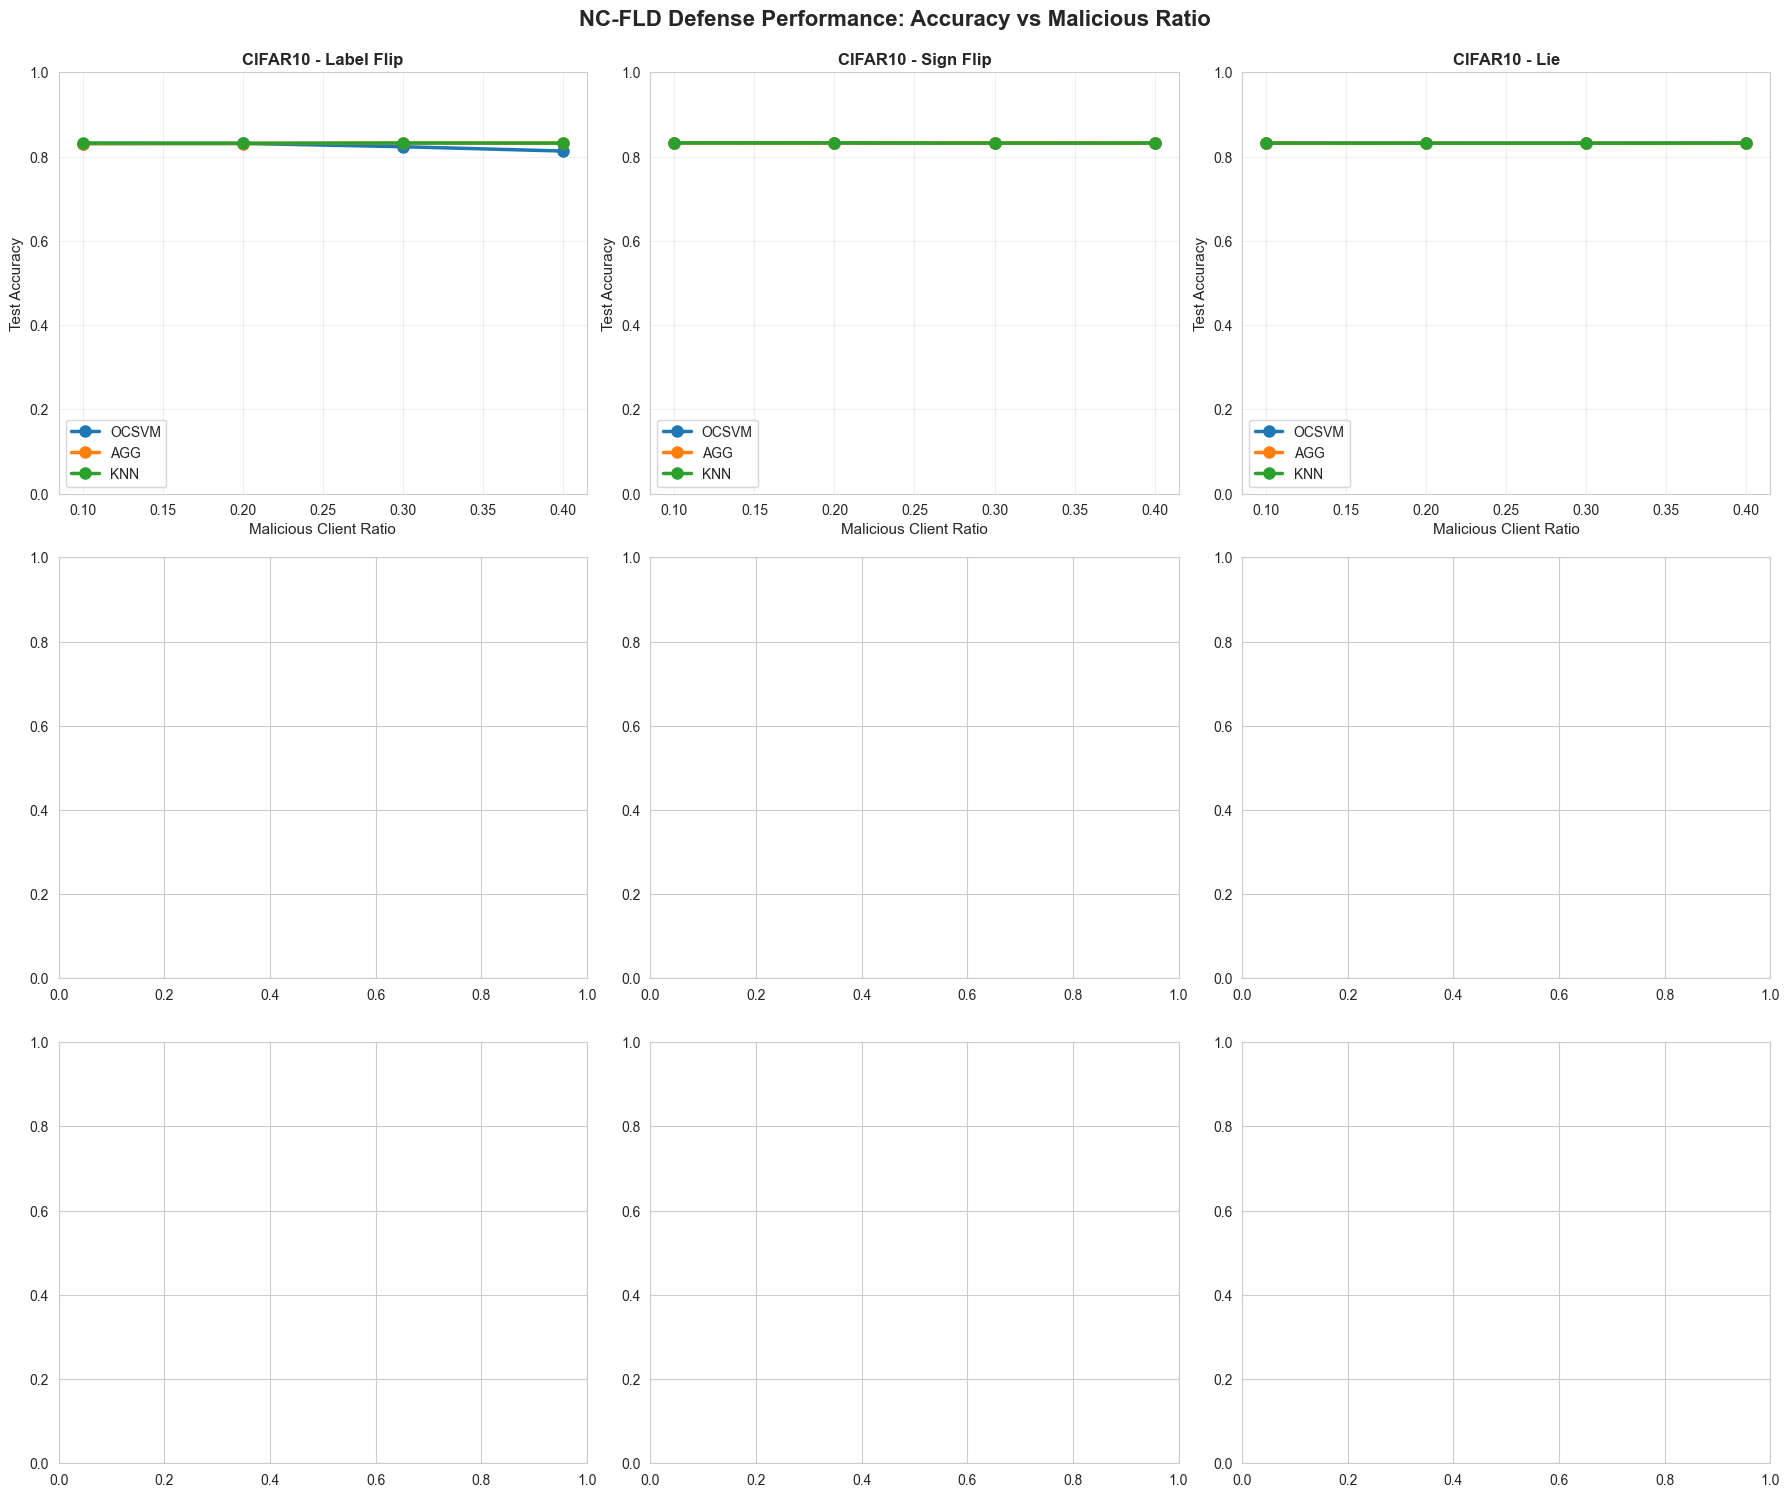

In [25]:
# Plot accuracy vs malicious ratio
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('NC-FLD Defense Performance: Accuracy vs Malicious Ratio', 
             fontsize=16, fontweight='bold', y=0.995)

datasets = df['dataset'].unique()
attacks = df['attack'].unique()

for i, dataset in enumerate(datasets):
    for j, attack in enumerate(attacks):
        ax = axes[i, j]
        data = df[(df['dataset'] == dataset) & (df['attack'] == attack)]
        
        if len(data) > 0:
            for defense in ['ocsvm', 'agg', 'knn']:
                defense_data = data[data['defense'] == defense].sort_values('malicious_ratio')
                if len(defense_data) > 0:
                    ax.plot(defense_data['malicious_ratio'], 
                           defense_data['final_accuracy'],
                           marker='o', label=defense.upper(), linewidth=2.5, markersize=8)
            
            ax.set_xlabel('Malicious Client Ratio', fontsize=11)
            ax.set_ylabel('Test Accuracy', fontsize=11)
            ax.set_title(f'{dataset.upper()} - {attack.replace("_", " ").title()}', 
                        fontsize=12, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('accuracy_vs_malicious_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 2: Defense Method Comparison

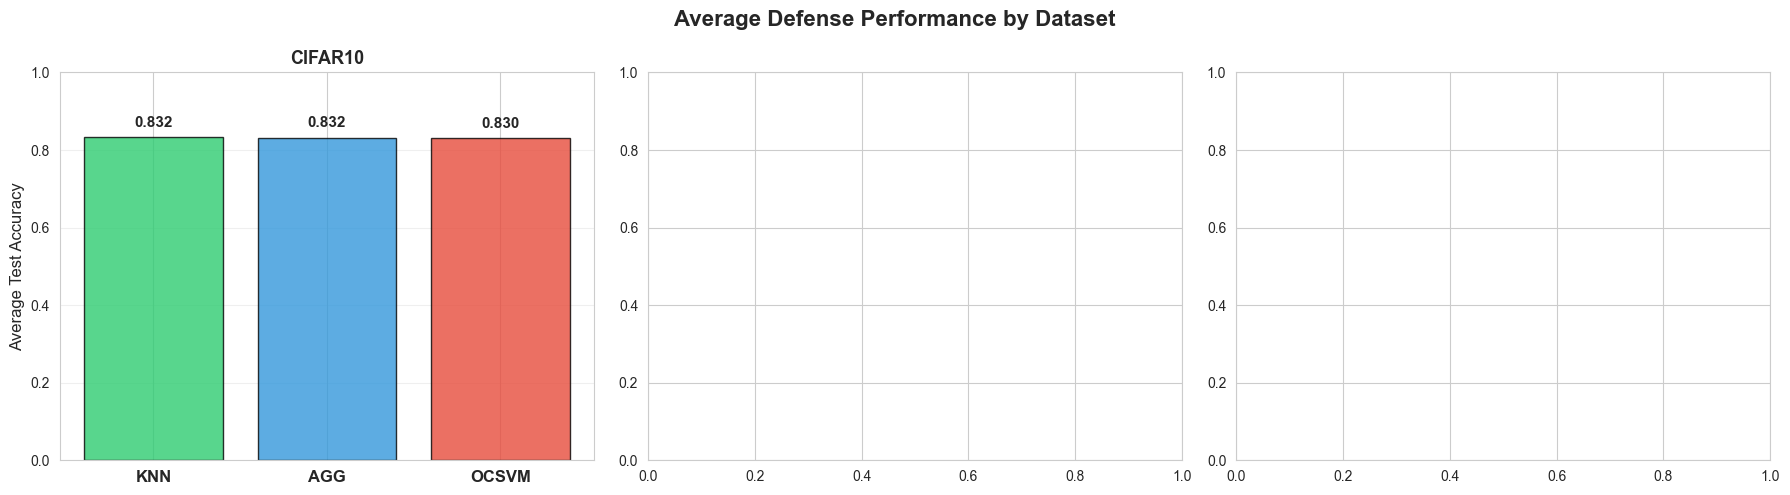

In [26]:
# Bar plot comparing defense methods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Average Defense Performance by Dataset', fontsize=16, fontweight='bold')

for i, dataset in enumerate(datasets):
    ax = axes[i]
    data = df[df['dataset'] == dataset]
    defense_avg = data.groupby('defense')['final_accuracy'].mean().sort_values(ascending=False)
    
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    bars = ax.bar(range(len(defense_avg)), defense_avg.values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_xticks(range(len(defense_avg)))
    ax.set_xticklabels([d.upper() for d in defense_avg.index], fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Test Accuracy', fontsize=12)
    ax.set_title(f'{dataset.upper()}', fontsize=13, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
               f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('defense_method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 3: Attack Impact Heatmap

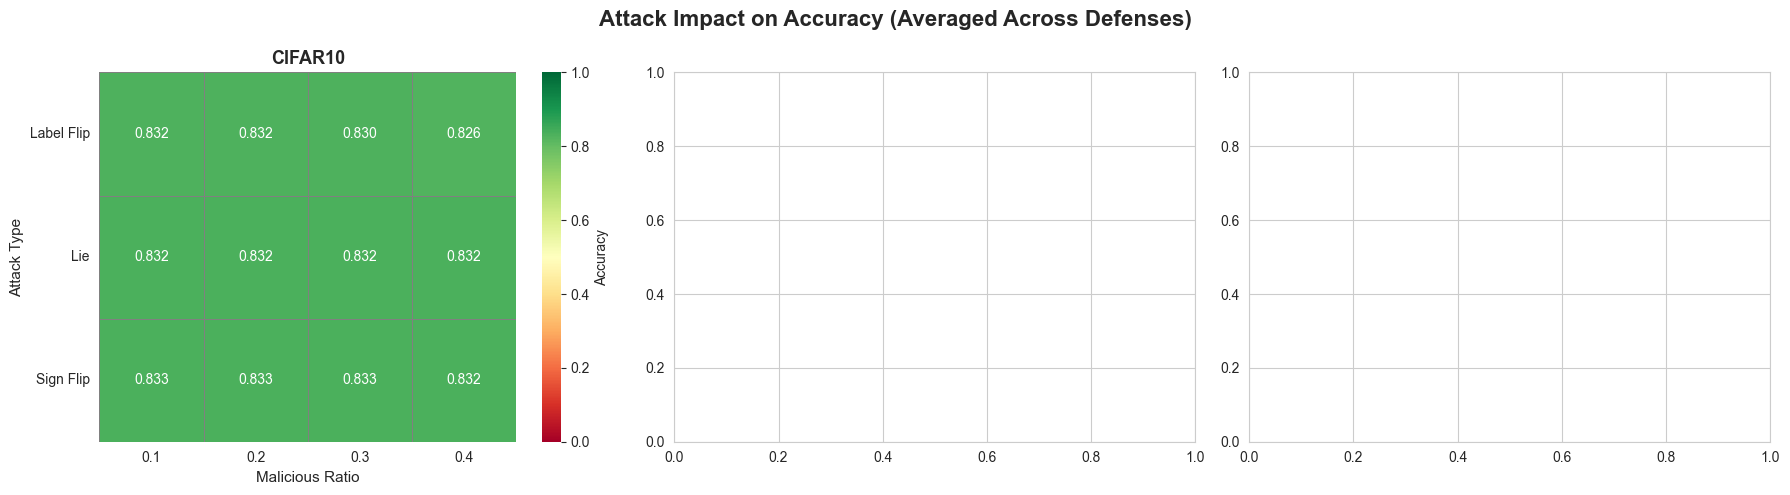

In [27]:
# Heatmap showing attack impact
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Attack Impact on Accuracy (Averaged Across Defenses)', 
             fontsize=16, fontweight='bold')

for i, dataset in enumerate(datasets):
    ax = axes[i]
    data = df[df['dataset'] == dataset]
    
    heatmap_data = data.pivot_table(
        values='final_accuracy',
        index='attack',
        columns='malicious_ratio',
        aggfunc='mean'
    )
    
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
                vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Accuracy'},
                linewidths=0.5, linecolor='gray')
    ax.set_title(f'{dataset.upper()}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Malicious Ratio', fontsize=11)
    ax.set_ylabel('Attack Type', fontsize=11)
    ax.set_yticklabels([a.replace('_', ' ').title() for a in heatmap_data.index], rotation=0)

plt.tight_layout()
plt.savefig('attack_impact_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Statistical Analysis

In [28]:
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

print("\n1. Overall Accuracy Statistics:")
print(df['final_accuracy'].describe())

print("\n2. Best Performing Configurations (Top 10):")
top_10 = df.nlargest(10, 'final_accuracy')[['dataset', 'attack', 'malicious_ratio', 'defense', 'final_accuracy']]
print(top_10.to_string(index=False))

print("\n3. Worst Performing Configurations (Bottom 10):")
bottom_10 = df.nsmallest(10, 'final_accuracy')[['dataset', 'attack', 'malicious_ratio', 'defense', 'final_accuracy']]
print(bottom_10.to_string(index=False))

print("\n4. Average Accuracy by Defense Method:")
defense_stats = df.groupby('defense')['final_accuracy'].agg(['mean', 'std', 'min', 'max', 'count'])
print(defense_stats.to_string())

print("\n5. Average Accuracy by Attack Type:")
attack_stats = df.groupby('attack')['final_accuracy'].agg(['mean', 'std', 'min', 'max', 'count'])
print(attack_stats.to_string())

print("\n6. Average Accuracy by Dataset:")
dataset_stats = df.groupby('dataset')['final_accuracy'].agg(['mean', 'std', 'min', 'max', 'count'])
print(dataset_stats.to_string())

print("\n7. Average Accuracy by Malicious Ratio:")
ratio_stats = df.groupby('malicious_ratio')['final_accuracy'].agg(['mean', 'std', 'min', 'max'])
print(ratio_stats.to_string())


STATISTICAL SUMMARY

1. Overall Accuracy Statistics:
count    36.000000
mean      0.831458
std       0.003431
min       0.813400
25%       0.832000
50%       0.832300
75%       0.832425
max       0.833000
Name: final_accuracy, dtype: float64

2. Best Performing Configurations (Top 10):
dataset     attack  malicious_ratio defense  final_accuracy
cifar10  sign_flip              0.3     agg          0.8330
cifar10  sign_flip              0.2     knn          0.8328
cifar10  sign_flip              0.1   ocsvm          0.8327
cifar10  sign_flip              0.1     knn          0.8327
cifar10  sign_flip              0.1     agg          0.8326
cifar10  sign_flip              0.2     agg          0.8326
cifar10 label_flip              0.3     knn          0.8325
cifar10  sign_flip              0.4     knn          0.8325
cifar10        lie              0.4   ocsvm          0.8325
cifar10 label_flip              0.1     knn          0.8324

3. Worst Performing Configurations (Bottom 10):
dat

## Generate Comprehensive Report

In [ ]:
# Create comprehensive text report
with open('nc_fld_experiment_report.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("NC-FLD FEDERATED LEARNING DEFENSE\n")
    f.write("COMPREHENSIVE EXPERIMENT REPORT\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Total Experiments Completed: {len(df)}\n\n")
    
    f.write("="*80 + "\n")
    f.write("OVERALL SUMMARY TABLE\n")
    f.write("="*80 + "\n\n")
    f.write(summary_pivot.to_string())
    f.write("\n\n")
    
    for dataset in datasets:
        f.write("="*80 + "\n")
        f.write(f"{dataset.upper()} DETAILED RESULTS\n")
        f.write("="*80 + "\n\n")
        df_dataset = df[df['dataset'] == dataset]
        pivot = df_dataset.pivot_table(
            values='final_accuracy',
            index=['attack', 'malicious_ratio'],
            columns='defense',
            aggfunc='mean'
        )
        f.write(pivot.to_string())
        f.write("\n\n")
    
    f.write("="*80 + "\n")
    f.write("KEY FINDINGS\n")
    f.write("="*80 + "\n\n")
    
    best_defense = df.groupby('defense')['final_accuracy'].mean().idxmax()
    best_defense_acc = df.groupby('defense')['final_accuracy'].mean().max()
    f.write(f"Best Defense Method: {best_defense.upper()} (Avg Accuracy: {best_defense_acc:.4f})\n")
    
    most_robust = df.groupby('attack')['final_accuracy'].mean().idxmax()
    f.write(f"Most Robust Against: {most_robust.replace('_', ' ').title()} Attack\n")
    
    best_dataset = df.groupby('dataset')['final_accuracy'].mean().idxmax()
    f.write(f"Best Dataset Performance: {best_dataset.upper()}\n")

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nGenerated Files:")
print("  1. nc_fld_experiment_results.csv - Raw results data")
print("  2. summary_accuracy_table.csv - Summary pivot table")
print("  3. mnist_results_table.csv - MNIST detailed results")
print("  4. cifar10_results_table.csv - Fashion-MNIST detailed results")
print("  5. cifar10_results_table.csv - CIFAR-10 detailed results")
print("  6. accuracy_vs_malicious_ratio.png - Line plots")
print("  7. defense_method_comparison.png - Bar charts")
print("  8. attack_impact_heatmap.png - Heatmaps")
print("  9. nc_fld_experiment_report.txt - Comprehensive text report")
print("\n" + "="*80)


ALL EXPERIMENTS COMPLETED SUCCESSFULLY!

Generated Files:
  1. nc_fld_experiment_results.csv - Raw results data
  2. summary_accuracy_table.csv - Summary pivot table
  3. mnist_results_table.csv - MNIST detailed results
  4. cifar10_results_table.csv - Fashion-MNIST detailed results
  5. cifar10_results_table.csv - CIFAR-10 detailed results
  6. accuracy_vs_malicious_ratio.png - Line plots
  7. defense_method_comparison.png - Bar charts
  8. attack_impact_heatmap.png - Heatmaps
  9. nc_fld_experiment_report.txt - Comprehensive text report

